<a href="https://colab.research.google.com/github/Allen123321/D-L/blob/master/C_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-gpu

    100% |████████████████████████████████| 345.2MB 44kB/s 


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive


In [0]:
import os
os.chdir("drive/C-DCGAN")


In [0]:
!ls

C-DCGAN  MNIST_data


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d instead.
Dis_losses: 1.713646, Gen_

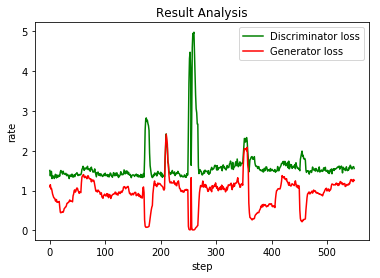

In [0]:
import os, time, random,itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import cv2
# 保存图片
dirpath = 'GAN/'
model = 'GAN_MINIST'
if not os.path.isdir(dirpath):
    os.mkdir(dirpath)
if not os.path.isdir(dirpath + 'FakeImg'):
    os.mkdir(dirpath + 'FakeImg')
# 初始化
IMAGE_SIZE = 28
onehot = np.eye(10)
noise_ = np.random.normal(0, 1, (10, 1, 1, 100))
fixed_noise_ = noise_
fixed_label_ = np.zeros((10, 1))
#用于最后显示十组图像
for i in range(9):
    fixed_noise_ = np.concatenate([fixed_noise_, noise_], 0)
    temp = np.ones((10, 1)) + i
    fixed_label_ = np.concatenate([fixed_label_, temp], 0)
fixed_label_ = onehot[fixed_label_.astype(np.int32)].reshape((100, 1, 1, 10))
batch_size = 100
#一共迭代20次
step = 40
#设置一个全局的计数器
global_step = tf.Variable(0, trainable=False)
#设置学习率
lr = tf.train.exponential_decay(0.0002, global_step, 500, 0.95, staircase=True)
#加载数据集Batch大小：100
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])

def leaky_relu(X, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

def Generator(x, labels, Training=True, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        #初始化参数
        W = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b = tf.constant_initializer(0.0)
        #把数据和标签进行连接
        concat = tf.concat([x, labels], 3)
        #第一次反卷积,卷积核大小为7*7，输出维度256
        out_1 = tf.layers.conv2d_transpose(concat, 256, [7, 7],
                                           strides=(1, 1),
                                           padding='valid',
                                           kernel_initializer=W,
                                           bias_initializer=b)
        out_1 = tf.layers.batch_normalization(out_1, training=Training)#batch norm
        out_1 = leaky_relu(out_1, 0.2)
         #第二次反卷机，卷积核大小为5*5，输出维度128
        out_2 = tf.layers.conv2d_transpose(out_1, 128, [5, 5],
                                           strides=(2, 2),
                                           padding='same',
                                           kernel_initializer=W,
                                           bias_initializer=b)
        out_2 = tf.layers.batch_normalization(out_2, training=Training)#batch norm
        out_2 = leaky_relu(out_2, 0.2)
         #第三次反卷机，卷积核大小5*5，输出维度1
        out_3 = tf.layers.conv2d_transpose(out_2, 1, [5, 5],
                                           strides=(2, 2),
                                           padding='same',
                                           kernel_initializer=W,
                                           bias_initializer=b)
        out_3 = tf.nn.tanh(out_3)
        return out_3

def Discriminator(x, real, Training=True, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        #初始化参数
        W = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b = tf.constant_initializer(0.0)
        #把数据和标签进行连接
        concat = tf.concat([x, real], 3)
        #第一次卷积 卷积核为5*5 输出维度为128
        out_1 = tf.layers.conv2d(concat, 128, [5, 5],
                                 strides=(2, 2),
                                 padding='same',
                                 kernel_initializer=W,
                                 bias_initializer=b)
        out_1 = leaky_relu(out_1, 0.2)
        # 第二次卷积 卷积核为5*5 输出维度256
        out_2 = tf.layers.conv2d(out_1, 256, [5, 5],
                                 strides=(2, 2),
                                 padding='same',
                                 kernel_initializer=W,
                                 bias_initializer=b)
        out_2 = tf.layers.batch_normalization(out_2, training=Training)#batch norm
        out_2 = leaky_relu(out_2, 0.2)
        #第三次卷积，卷积和为7*7，输出维度为1
        out_3 = tf.layers.conv2d(out_2, 1, [7, 7],
                                 strides=(1, 1),
                                 padding='valid',
                                 kernel_initializer=W)
        logits = tf.nn.sigmoid(out_3)
        return logits, out_3

def show_result(num_epoch, path, show = False , save = False ):
    test_images = sess.run(G_noise, {noise: fixed_noise_, labels: fixed_label_, Training: False})
    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (IMAGE_SIZE, IMAGE_SIZE)), cmap='gray')
    label = 'Step {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    if save:
        plt.savefig(path)
    if show:
        plt.show()
    else:
        plt.close()

x = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, 1))
noise = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
labels = tf.placeholder(tf.float32, shape=(None, 1, 1, 10))
real = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, 10))
Training = tf.placeholder(dtype=tf.bool)

# 运行生成网络哦
G_noise = Generator(noise, labels, Training)
# 运行判别网络
D_real, D_real_logits = Discriminator(x, real, Training)
D_fake, D_fake_logits = Discriminator(G_noise, real, Training, reuse=True)
# 计算每个网络的损失函数
#算判别器真值的损失函数
Dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits,
                                                                       labels=tf.ones([batch_size, 1, 1, 1])))
#算判别器噪声生成图片的损失函数
Dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits,
                                                                       labels=tf.zeros([batch_size, 1, 1, 1])))
#损失函数求和
Dis_loss = Dis_loss_real + Dis_loss_fake
#计算生成器的损失函数
Gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits,
                                                                  labels=tf.ones([batch_size, 1, 1, 1])))
# 提取每个网络的变量
tf_vars = tf.trainable_variables()
Dis_vars = [var for var in tf_vars if var.name.startswith('Discriminator')]
Gen_vars = [var for var in tf_vars if var.name.startswith('Generator')]
# 调整参数 设计是用来控制计算流图的，给图中的某些计算指定顺序
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    optim = tf.train.AdamOptimizer(lr, beta1=0.5)#寻找全局最优点的优化算法，引入了二次方梯度校正 衰减率0.5
    D_optim = optim.minimize(Dis_loss, global_step=global_step, var_list=Dis_vars)#优化更新训练的模型参数，也可以为全局步骤(global step)计数
    G_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(Gen_loss, var_list=Gen_vars)#寻找全局最优点的优化算法，引入了二次方梯度校正 衰减率0.5


# 开启一个session，
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
#对MNIST做一下处理
train_set = (mnist.train.images - 0.5) / 0.5
train_label = mnist.train.labels
for i in range(step):
    Gen_losses = []
    Dis_losses = []
    i_start_time = time.time()
    index = random.sample(range(0, train_set.shape[0]), train_set.shape[0])
    new_set = train_set[index]
    new_label = train_label[index]
    for j in range(new_set.shape[0] // batch_size):
        #对判别器进行更新
        x_ = new_set[j*batch_size:(j+1)*batch_size]
        label_ = new_label[j*batch_size:(j+1)*batch_size].reshape([batch_size, 1, 1, 10])
        real_ = label_ * np.ones([batch_size, IMAGE_SIZE, IMAGE_SIZE, 10])
        noise_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))
        loss_d_, _ = sess.run([Dis_loss, D_optim], {x: x_, noise: noise_, real: real_, labels: label_, Training: True})
        #对生成器进行更新
        noise_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))
        y_ = np.random.randint(0, 9, (batch_size, 1))
        label_ = onehot[y_.astype(np.int32)].reshape([batch_size, 1, 1, 10])
        real_ = label_ * np.ones([batch_size, IMAGE_SIZE, IMAGE_SIZE, 10])
        loss_g_, _ = sess.run([Gen_loss, G_optim], {noise: noise_, x: x_, real: real_, labels: label_, Training: True})
        #计算训练过程中的损失函数
        errD_fake = Dis_loss_fake.eval({noise: noise_, labels: label_, real: real_, Training: False})
        errD_real = Dis_loss_real.eval({x: x_, labels: label_, real: real_, Training: False})
        errG = Gen_loss.eval({noise: noise_, labels: label_, real: real_, Training: False})
        Dis_losses.append(errD_fake + errD_real)
        Gen_losses.append(errG)
        if(j%100==0):
            pic = dirpath + 'FakeImg/' + model +str(i + 1) + '_' + str(i *new_set.shape[0] // batch_size + j+1) + '.png'
            show_result((i + 1),  path=pic ,save=True)
    print('Dis_losses: %.6f, Gen_losses: %.6f' % (np.mean(Dis_losses), np.mean(Gen_losses)))
    pic = dirpath + 'FakeImg/' + model + str(i + 1) + '.png'
    show_result((i + 1), path=pic , save=True )
sess.close()

plt.title('Result Analysis')
plt.plot(Dis_losses, color='green', label='Discriminator loss')
plt.plot(Gen_losses, color='red', label='Generator loss')

plt.legend()
plt.xlabel('step')
plt.ylabel('rate')
plt.savefig("loss.jpg")
plt.show()

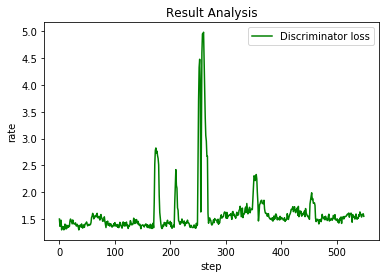

In [0]:
plt.title('Result Analysis')
plt.plot(Dis_losses, color='green', label='Discriminator loss')


plt.legend()
plt.xlabel('step')
plt.ylabel('rate')
plt.savefig("D_loss.jpg")
plt.show()

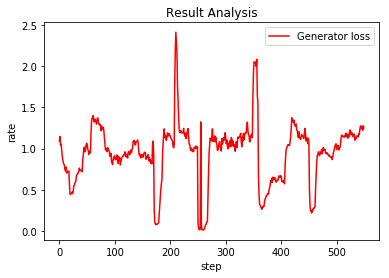

In [0]:
plt.title('Result Analysis')
plt.plot(Gen_losses, color='red', label='Generator loss')

plt.legend()
plt.xlabel('step')
plt.ylabel('rate')
plt.savefig("G_loss.jpg")
plt.show()